---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 2. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [4]:
#!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

Archive:  UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerced_LandUs

Use this first cell to import the necessary libraries.

In [6]:
# import libraries here.

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
import cv2


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


In [8]:
# Write your proposed solution code here. Create more code cells if you find it necessary

from PIL import Image #PIL is a library that provides tools for opening, manipulating, and saving images in various formats.

def check_missing_data(dataset_path):
    """ A function to check for unreadable images and to confirm consistency
        in the dataset.
        Basic statistics are looked at for the images.
    """
    missing_count = 0
    image_sizes = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):  # Skip files, process only directories.
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if not img_name.lower().endswith(valid_extensions):
                continue  # Skip non-image files

            try:
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # Store image size.
            except Exception as e:
                print(f"Corrupt image detected: {img_path}, Error: {e}")
                missing_count += 1
    
    print(f"Total Corrupt or Unreadable Images: {missing_count}")
    
    if image_sizes:
        image_sizes = np.array(image_sizes)
        print(f"Image Size Stats: Mean={image_sizes.mean(axis=0)}, Std={image_sizes.std(axis=0)}")



# Define transforms (Normalization & Augmentation).
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "UCMerced_LandUse/Images"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Perform Missing Data Check.
check_missing_data(dataset_path)

Total Corrupt or Unreadable Images: 0


Total Classes: 21
Categories: ['forest', 'buildings', 'river', 'mobilehomepark', 'harbor', 'golfcourse', 'agricultural', 'runway', 'baseballdiamond', 'overpass', 'chaparral', 'tenniscourt', 'intersection', 'airplane', 'parkinglot', 'sparseresidential', 'mediumresidential', 'denseresidential', 'beach', 'freeway', 'storagetanks']
forest: 100 images
buildings: 100 images
river: 100 images
mobilehomepark: 100 images
harbor: 100 images
golfcourse: 100 images
agricultural: 100 images
runway: 100 images
baseballdiamond: 100 images
overpass: 100 images
chaparral: 100 images
tenniscourt: 100 images
intersection: 100 images
airplane: 100 images
parkinglot: 100 images
sparseresidential: 100 images
mediumresidential: 100 images
denseresidential: 100 images
beach: 100 images
freeway: 100 images
storagetanks: 100 images


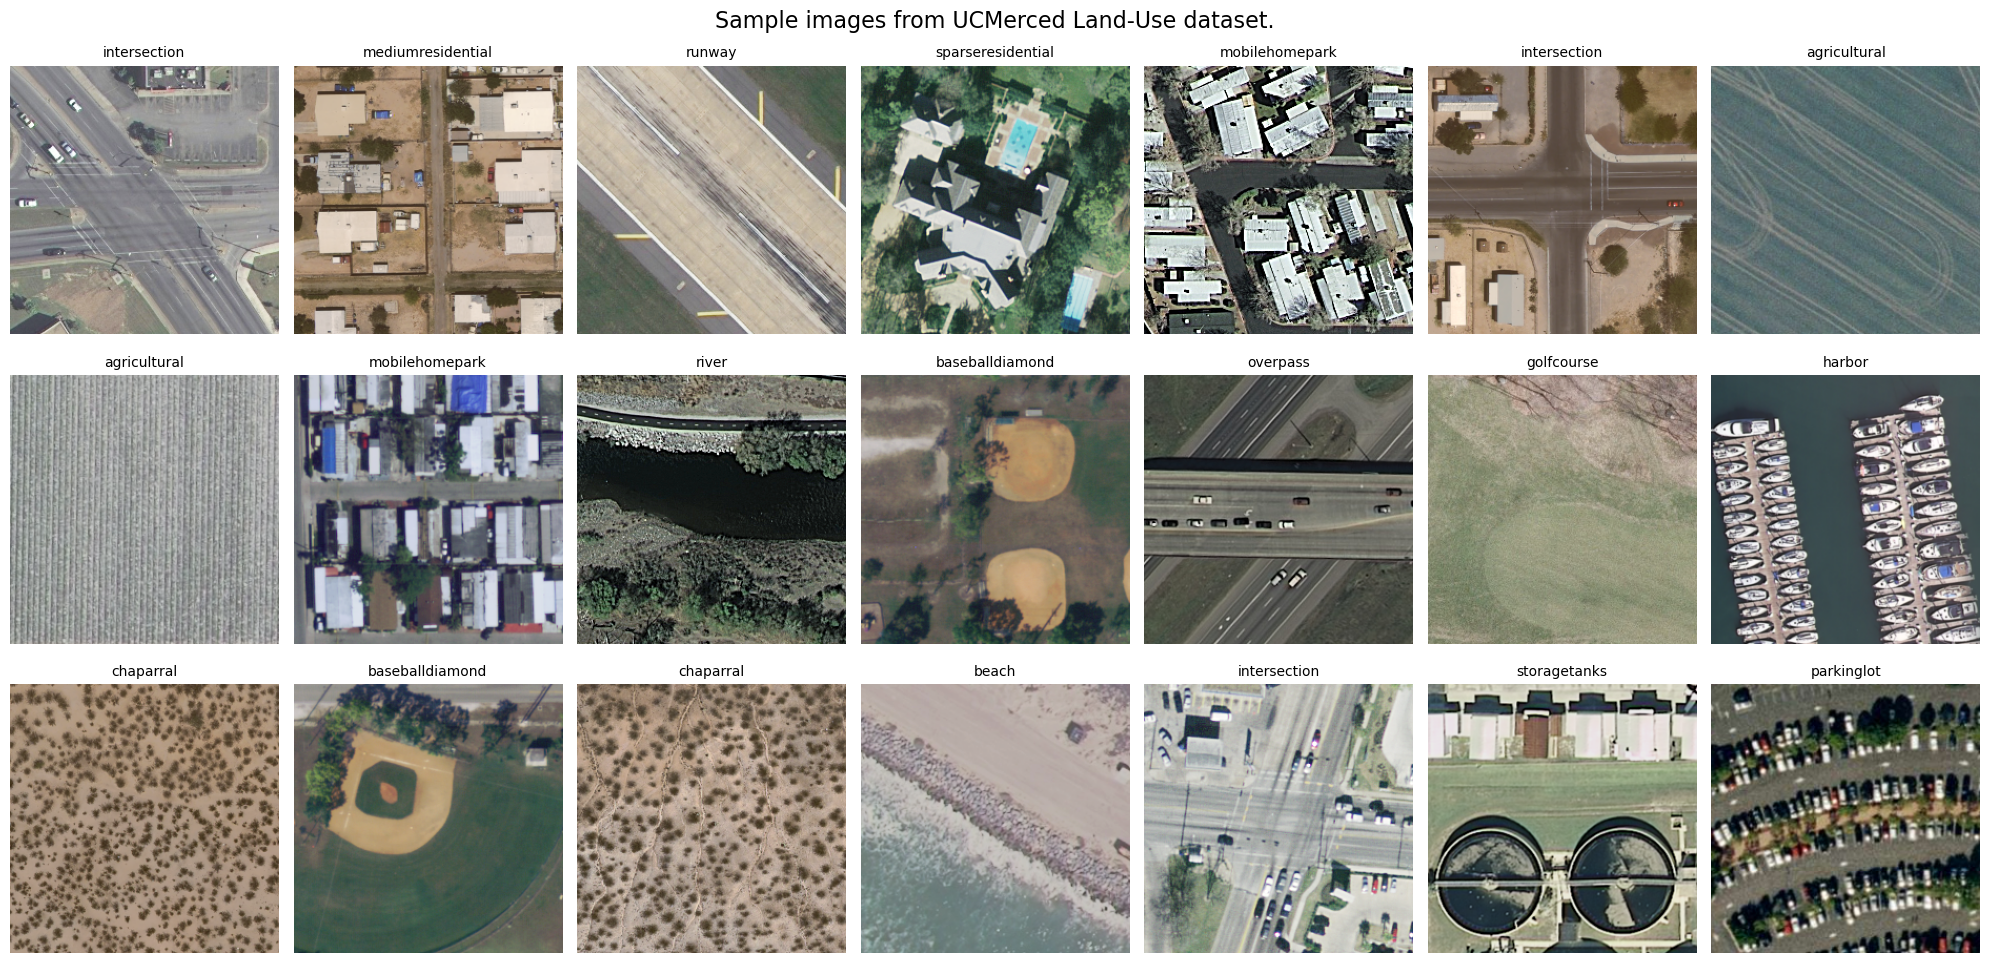

In [9]:
# Listing categories.
categories = os.listdir(dataset_path)
print(f"Total Classes: {len(categories)}")
print("Categories:", categories[:21])  # Display first 5 class names.

# Count images in each class.
for category in categories:
    class_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(class_path))
    print(f"{category}: {num_images} images")

# Function to show random images before normalization.
def show_original_images(num_images=21, rows=3, cols=7):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))  # Adjust figure size

    for i in range(num_images):
        category = random.choice(categories)  
        class_path = os.path.join(dataset_path, category)
        img_name = random.choice(os.listdir(class_path))  
        img_path = os.path.join(class_path, img_name)

        # Read and convert image (from BGR to RGB).
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Determine row & column index.
        row, col = divmod(i, cols)

        # Display image.
        axes[row, col].imshow(img)
        axes[row, col].axis("off")  # Hide axes.
        axes[row, col].set_title(category, fontsize=10)  # Show category name.

    plt.suptitle("Sample images from UCMerced Land-Use dataset.", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display images.
show_original_images()

In [10]:
# Splitting Data.
train_size = int(0.8 * len(dataset)) # 80% train data.
test_size = len(dataset) - train_size # 20% test data.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


---

# 2. **Neural Networks**

Here, you need to:

1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



In [12]:
# Write your proposed solution code here. Create more code cells if you find it necessary
# Define a simple CNN model
   
class NeuralNetwork(nn.Module):
    """ 
    Intialising a class to create our Custom CNN architecture to classify the dataset images.
    """
    
    def __init__(self, num_classes):
        """ 
        A function to define the layers of the CNN including: 
        Convolutional layer,
        ReLU,
        Max pooling layer,
        Fully connected layer. 
        """
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # Covolutional Layer.
        self.relu = nn.ReLU() # ReLu.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Max pooling layer.
        self.fc1 = nn.Linear(32 * 128 * 128, num_classes) # Fully connected layer.

    def forward(self, x):
        """
        A function to define the flow (forward pass) of input data through the CNN.
        Applies each layer of the CNN, flattens the data and passes it through the neural network
        to produce an output. 
        Output: final scores.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [13]:
# Load ResNet-18 model.
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(dataset.classes))

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Initialise Model.
num_classes = len(dataset.classes)
Neural_Network = NeuralNetwork(num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss() # Standard Loss Function.
optimizer_cnn = optim.Adam(Neural_Network.parameters(), lr=0.001) # Optimiser for Neural Network (Adam).
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.001) # Optimiser for ResNet-18 (Adam).


In [ ]:

# Training Function
def train_model(model, train_loader, optimizer, num_epochs=10):
    """ 
    A function to train our NeuralNetwork model. 
    Input: model, data loader, optimizer (Adam) and epochs (default, 10)
    Output: Training loss and accuracy scores.
    """
    model.train()
    losses, accuracies = [], [] # Loss and accuracy stored for each epoch.
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0 # Reset counters.
        for images, labels in train_loader:
            optimizer.zero_grad() 
            outputs = model(images) # Forward pass.
            loss = criterion(outputs, labels) # Compute loss.
            loss.backward() # Backpropagation.
            optimizer.step() # Model weights.

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # Generate predicted class.
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Correct predictions are counted.

        # Average loss and accuracy stored.
        losses.append(running_loss / len(train_loader))
        accuracies.append(100 * correct / total)
        # Print progress for each epoch.
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]}, Train Accuracy: {accuracies[-1]}%")
    return losses, accuracies

# Train both models
cnn_losses, cnn_accuracies = train_model(Neural_Network, train_loader, optimizer_cnn)
resnet_losses, resnet_accuracies = train_model(resnet18, train_loader, optimizer_resnet)

# Plot training loss for each model.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(cnn_losses, label="Neural Network Loss")
axes[0].plot(resnet_losses, label="ResNet-18 Loss")
axes[0].set_title("Training Loss Comparison")
axes[0].set_xlabel("Epoch Index")
axes[0].set_ylabel("Loss Value")
axes[0].legend()

# Plot training accuracy for each model.
axes[1].plot(cnn_accuracies, label="Neural Network  Train Accuracy")
axes[1].plot(resnet_accuracies, label="ResNet-18 Train Accuracy")
axes[1].set_title("Training Accuracy Comparison")
axes[0].set_xlabel("Epoch Index")
axes[0].set_ylabel("Accuracy (%)")
axes[1].legend()

plt.show()



Epoch 1/10, Loss: 26.795306813042117, Train Accuracy: 17.321428571428573%
Epoch 2/10, Loss: 5.041729432231975, Train Accuracy: 32.916666666666664%
Epoch 3/10, Loss: 4.244844207223856, Train Accuracy: 38.86904761904762%
Epoch 4/10, Loss: 2.2634986728992104, Train Accuracy: 49.82142857142857%
Epoch 5/10, Loss: 1.6637420598066077, Train Accuracy: 58.392857142857146%
Epoch 6/10, Loss: 1.5464895052729912, Train Accuracy: 60.833333333333336%
Epoch 7/10, Loss: 1.3237672959858517, Train Accuracy: 65.53571428571429%
Epoch 8/10, Loss: 1.4612076586147524, Train Accuracy: 63.63095238095238%
Epoch 9/10, Loss: 1.1105910550873235, Train Accuracy: 69.4047619047619%
Epoch 10/10, Loss: 1.08932411895608, Train Accuracy: 70.5952380952381%
Epoch 1/10, Loss: 1.1200674586700943, Train Accuracy: 66.66666666666667%
Epoch 2/10, Loss: 0.5559189659806917, Train Accuracy: 82.61904761904762%
Epoch 3/10, Loss: 0.4277093347232297, Train Accuracy: 86.96428571428571%
Epoch 4/10, Loss: 0.3222866085059238, Train Accuracy

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


In [ ]:
# Write your proposed solution code here. Create more code cells if you find it necessary

# Model Evaluation
def evaluate_model(model, test_loader, model_name):
    """ Evaluates the ResNet model on test dataset. 
        Output: Classification metrics and Confusion Matrix.
                Includes: precision, recall, f-score, accuracy and macro-averages.
    """
    # Run model on test dataset
    model.eval() 
    y_true, y_pred = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print results
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Train Accuracy: {cnn_accuracies[-1] if 'Custom' in model_name else resnet_accuracies[-1]:.4f}%")
    print(f"Test Accuracy: {test_accuracy:.4f}%")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Evaluate Best Model
evaluate_model(Neural_Network, test_loader, "Neural Network")
evaluate_model(resnet18, test_loader, "ResNet-18")
